In [1]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:00


In [2]:
!pip install pandas_datareader

In [3]:
import os
import pandas as pd
import pandas_datareader.data as pdr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import itertools
import warnings
warnings.filterwarnings('ignore')

<ipython-input-3-357ad1edadd5>:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [4]:
import yfinance as yf
df = yf.download('005930.KS',
                     start='2022-01-01',
                     end='2022-05-12') # 005930 : 삼성전자 주가

df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,78800.0,79200.0,78300.0,78700.0,74562.328125,12427416
2022-01-05,78800.0,79000.0,76400.0,77400.0,73330.656250,25470640
2022-01-06,76700.0,77600.0,76600.0,76900.0,72856.953125,12931954
2022-01-07,78100.0,78400.0,77400.0,78300.0,74183.351562,15163757
2022-01-10,78100.0,78100.0,77100.0,78000.0,73899.125000,9947422


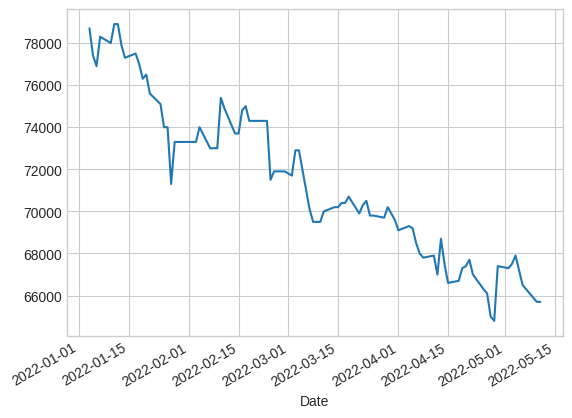

In [5]:
fig = df['Close'].plot()


# decomposition

시계열 데이터를 시계열 4개 요소(추세, 순환, 계절, 불규칙성)으로 분해하는 기법

추세 (Trend): 데이터가 장기적으로 증가하거나 감소하는것

순환 (cycle): 정치, 경제, 사회적 요인에 대한 변화로, 장기적인 변화 현상

계절 (seasenal): 특정 주기로 나타나는 패턴

불규칙(random): 설명할 수 없는 이상하고 예측이 불가능한 임의의 변동

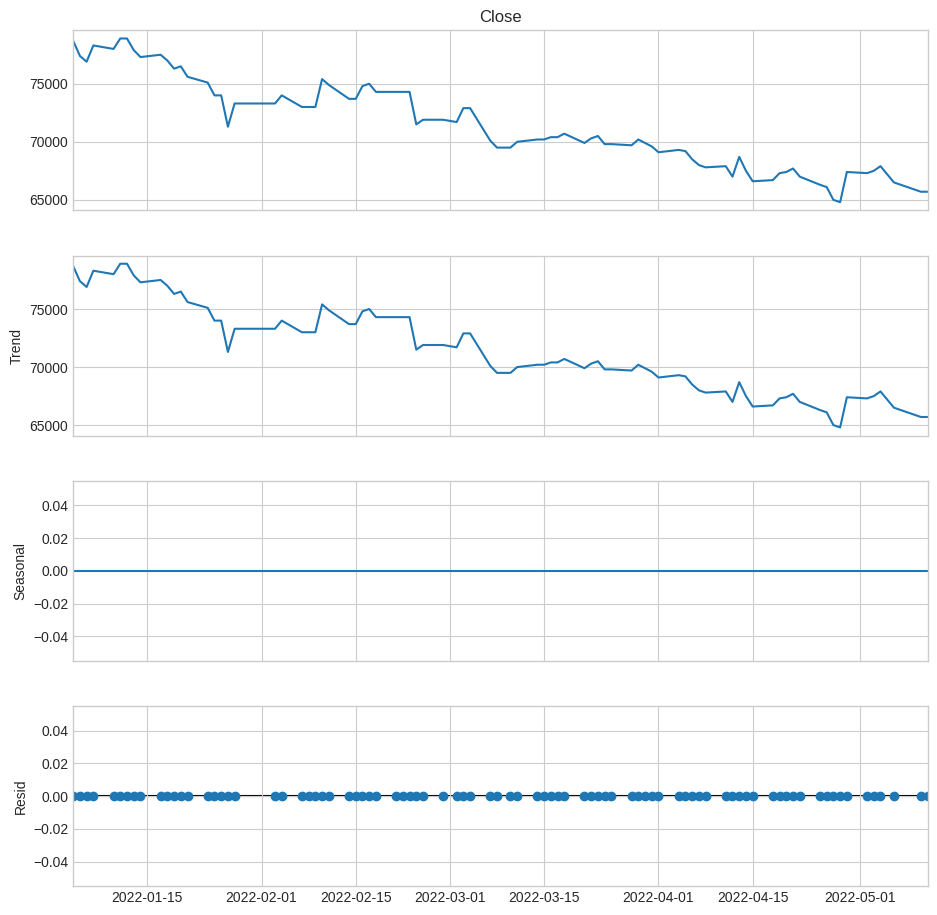

In [ ]:
# seasonal decomposition
# statsmodel의 tsa를 사용하여 디컴포지션 결과 확인 가능.

# 분해방법에는 additive와 multiplicative가 있다.
# additive 분해법 : y_t = S_t + T_t + R_t
# multiplicative 분해법 : y_t = S_t * T_t * R_t

decomposition = sm.tsa.seasonal_decompose(df['Close'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10, 10)
plt.show()

# 첫번째 플랏 : Observed, 원 시계열 데이터
# 두번째 플랏 : Trend, 추세, 시계열 데이터의 장기적인 변화 경향 # 하향하는 추세
# 세번째 플랏: Seasonal, 계절성, 주기적으로 반복되는 패턴, 그래프에서 패턴 안보임
# 네벗째 플랏 : Residual, 잔차, 원 데이터에서 추세와 계절성을 빼고서 남은 부분. 예측할 수 없는 불규칙한 변동 #  y값이 잔차. 날뛰어보이지 않아서 안정적.

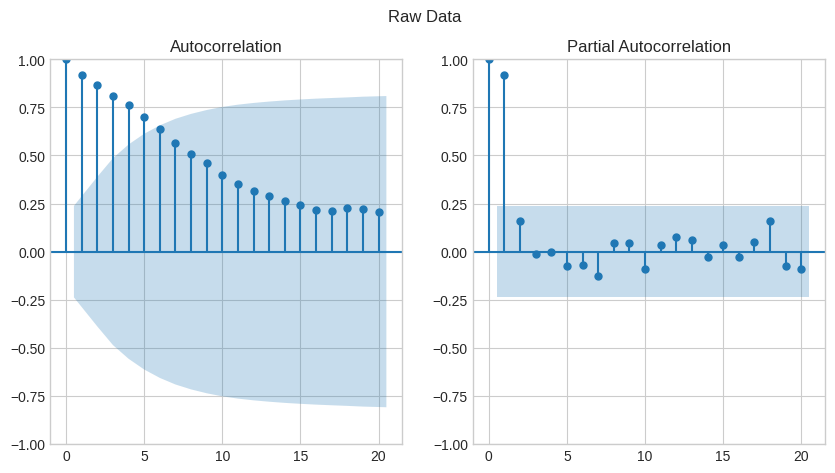

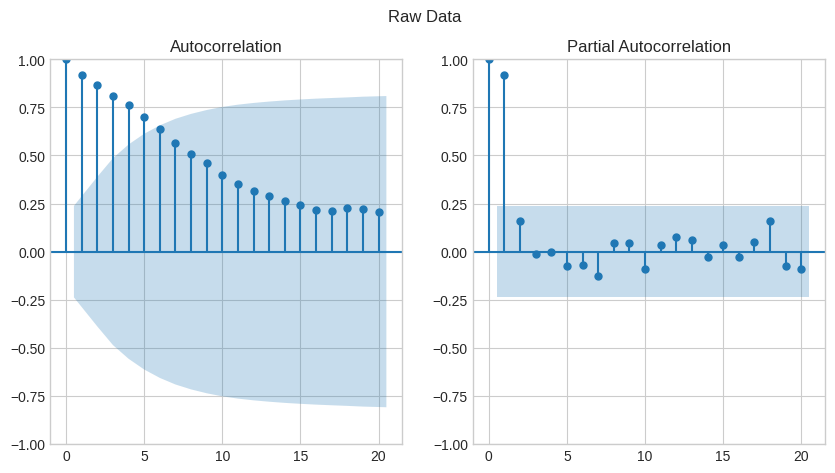

In [ ]:
# split 8 : 2
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=False)


# ACF, PACF plot
# 자기상관함수(Auto correlation function) 그래프 및 부분자기 상관 함수(partial auto correlation function) 그래프
# 자기 상관(Autocorrelation)이란 시계열 데이터 내에서 한 시점의 데이터 값이 이전 시점의 데이터 값과 얼마나 관련이 있는지를 측정하는 통계적 방법

# ACF는 시계열 데이터의 자기상관을 시차별로 표현
# 모든 시점의 누적상관관계
# 시차 1: X_t ~ X_t-1 간의 상관관계.
# 시차 2: X_t ~ X_t-2 간의 상관관계. (단, X_t-1 의 영향 존재)
# 시차 3: X_t ~ X_t-3 간의 상관관계. (단, X_t-1 과 X_t-2 의 영향 존재)

# PACF는 특정 시차에서의 부분 자기상관을 표현
#시차 1: X_t 와 X_t-1 간의 상관관계.
#시차 2: X_t 와 X_t-2 간의 상관관계 (단, X_t-1 의 영향을 제거한 후).
#시차 3: X_t 와 X_t-3 간의 상관관계 (단, X_t-1 과 X_t-2 의 영향을 제거한 후).

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data['Close'].values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data['Close'].values.squeeze(), lags=20, ax=ax[1])

# 그래프 해석:
# ACF와 PACF에서 막대기가 긴걸 보아 초기시차에서 높은 상관관계를 보이고, ACF 그래프만 천천히 감소하는 패턴 (과거의 값이 미래 값에 계속 영향을 주기 때문에)
# 이는 시계열 데이터가 non-stationary(비정상)일 가능성이 높음을 알려줌.
# 정상 시계열은 시간이 지나도 평균이나 패턴이 일정. 그래서 과거의 값이 미래에 미치는 영향이 빠르게 사라져,
# ACF 그래프에서 시차가 조금만 커져도 상관관계가 빠르게 0에 가까워진다.

# 비정상 시계열에서 과거 데이터가 계속해서 미래에 영향을 미친다는 것은 데이터의 평균과 분산이 시간이 지남에 따라 바뀐다는 의미
# (분산과 평균이 일정해야 모델이 안정적으로 예측 하는데 과거 때문에 계속 바뀜)

# stationary 시계열 데이터는 통계적 성질이 시간에 따라 변하지 않는 특성, 평균, 분산, 자기상관이 일정한 데이터를 말함.
# non-statinary 데이터 즉, 비정상성 데이터는 시계열 모델링과 예측에 적합하지 않기 때문에 정상성을 확보하기
# 위하여 차분을 진행해볼 수 있음

# ACF 결과 천천해 떨어지는 상관, PACF는 괜찮았음. 그래도 차분 진행

In [ ]:
# Non-stationary -> stationary 보정 (차분, difference)
# differencing
star = "*"
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['Close'].diff() # 차분
diff_train_data = diff_train_data.dropna() # 차분 후 생기는 결측치 제거
print(f'{star*15}Raw data{star*15}')
print(train_data['Close'].head())
print(f'{star*15}Differenced data{star*15}')
print(diff_train_data.head())

***************Raw data***************
Date
2022-01-04    78700.0
2022-01-05    77400.0
2022-01-06    76900.0
2022-01-07    78300.0
2022-01-10    78000.0
Name: Close, dtype: float64
***************Differenced data***************
Date
2022-01-05   -1300.0
2022-01-06    -500.0
2022-01-07    1400.0
2022-01-10    -300.0
2022-01-11     900.0
Name: Close, dtype: float64


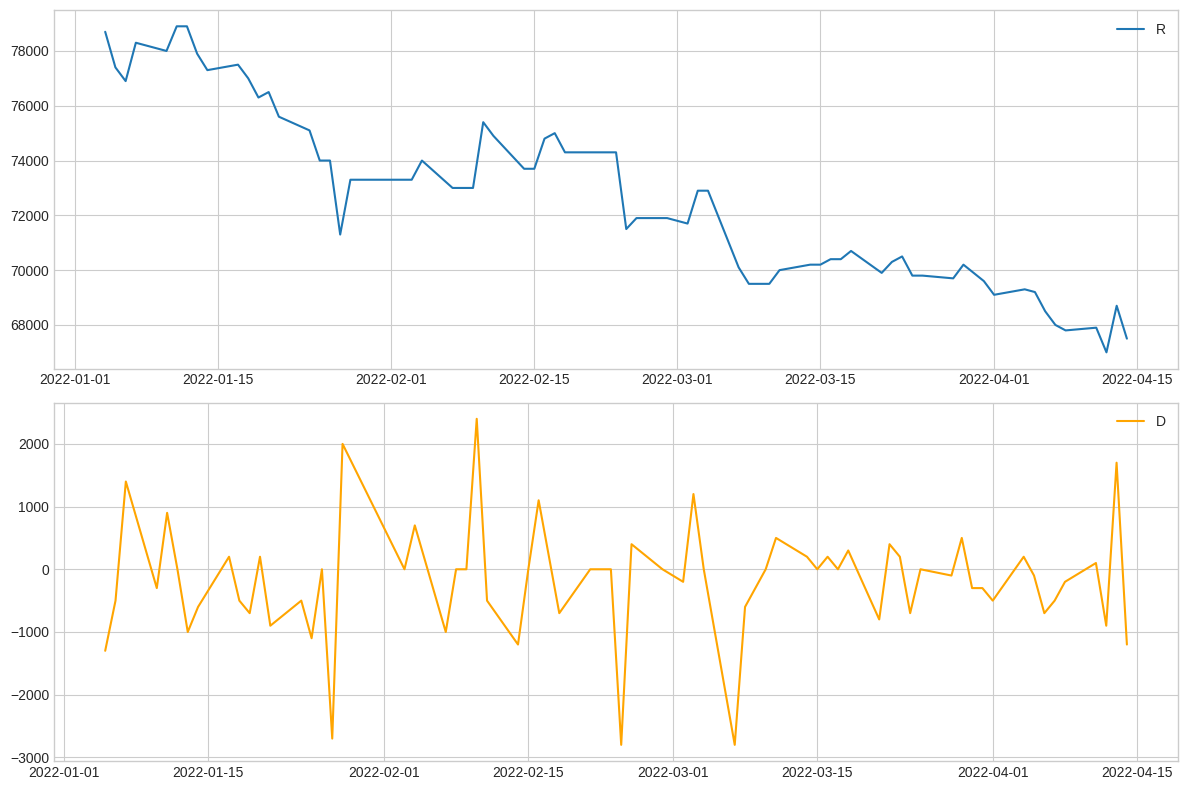

In [ ]:
# 차분 시각화
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.plot(train_data['Close'])
ax1.legend('Raw data (Non-stationary)')

ax2.plot(diff_train_data, color='orange' )
ax2.legend('Differenced data (stationary)')

plt.tight_layout()
plt.show()

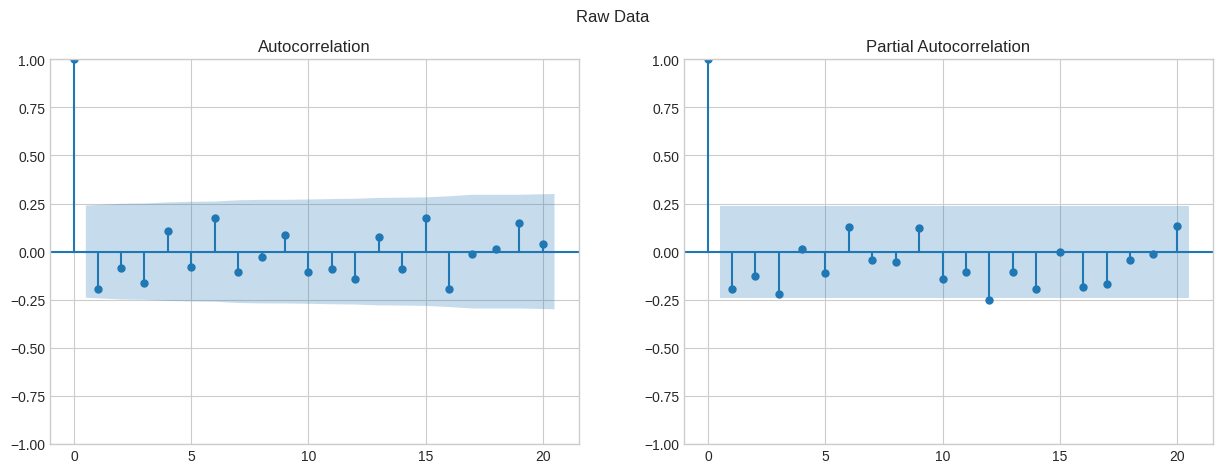

In [ ]:
# ACF, PACF plot

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=20, ax=ax[1])
plt.show()

In [ ]:
# 최적 파라미터 서치
p = range(0, 2) # 자기회귀(AR) 부분의 차수. 자기 회귀 모델이 몇 개의 과거 시점을 사용할지
d = range(1, 3) # 차분(differencing) 횟수. 비정상적일 때(평균이나 분산이 일정하지 않을 때) 정상성을 만들기 위해 데이터를 변환하는 방법
q = range(0, 2) # 이동 평균(MA) 부분의 차수. 과거 예측 오차들의 가중 평균

pdq = list(itertools.product(p, d, q))
AIC = []
for i in pdq :
    model = ARIMA(train_data['Close'].values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA pdq : {i} >> AIC : {round(model_fit.aic, 2)}')
    AIC.append(round(model_fit.aic, 2))

ARIMA pdq : (0, 1, 0) >> AIC : 1107.32
ARIMA pdq : (0, 1, 1) >> AIC : 1106.43
ARIMA pdq : (0, 2, 0) >> AIC : 1146.01
ARIMA pdq : (0, 2, 1) >> AIC : 1144.9
ARIMA pdq : (1, 1, 0) >> AIC : 1106.53
ARIMA pdq : (1, 1, 1) >> AIC : 1108.32
ARIMA pdq : (1, 2, 0) >> AIC : 1145.27
ARIMA pdq : (1, 2, 1) >> AIC : 1144.85


In [ ]:
# optimal paramter
optim = [(pdq[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print('Found Optimal Parameter :',optim)

Found Optimal Parameter : [((0, 1, 1), 1106.43)]


In [ ]:
model = ARIMA(train_data['Close'].values, order=(0, 1, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   68
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -551.217
Date:                Sun, 08 Sep 2024   AIC                           1106.433
Time:                        14:37:39   BIC                           1110.842
Sample:                             0   HQIC                          1108.178
                                 - 68                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0437      0.077     -0.564      0.573      -0.195       0.108
sigma2      8.165e+05    9.5e+04      8.599      0.000     6.3e+05       1e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.11   Jarque-Bera (JB):                17.81
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.39
Prob(H) (two-sided):                  0.03   Kurtosis:                         5.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# 예측 수행
forecast = model_fit.get_forecast(steps=len(test_data)) # 지정된 기간만큼 미래 값을 예측
pred_val = forecast.predicted_mean # 예측된 평균값
pred_ci = forecast.conf_int() # 예측 신뢰 구간(confidence interval)

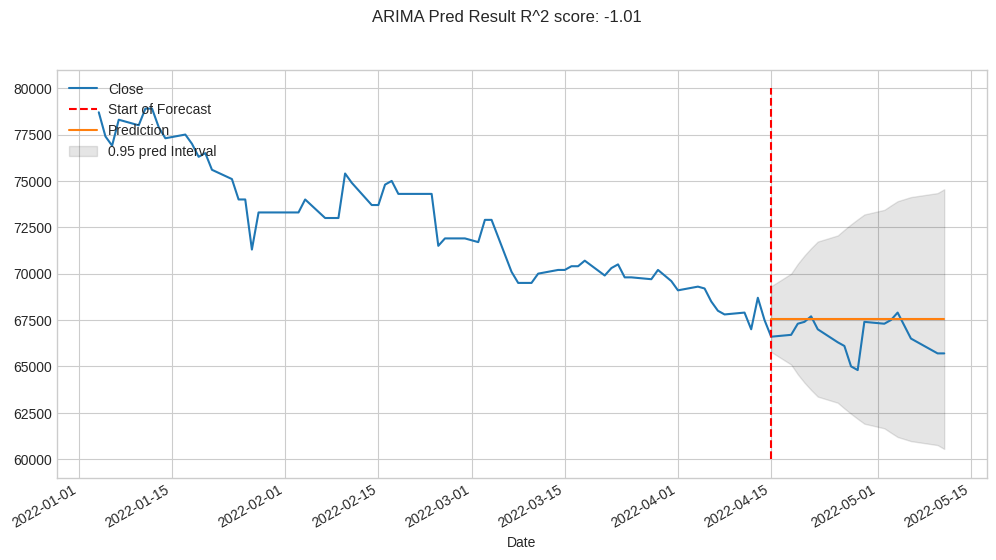

In [ ]:
# 상위/하위 예측 구간 추출
pred_ub = pred_ci[:, 1]  # 상위 예측 구간
pred_lb = pred_ci[:, 0]  # 하위 예측 구간

# 예측값의 인덱스 설정
pred_index = list(test_data.index)

# R^2 스코어 계산
r2 = r2_score(test_data['Close'].values, pred_val)

# 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax=ax)
ax.vlines('2022-04-15', 60000, 80000, linestyle='--', color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA Pred Result R^2 score: {round(r2, 2)}')
plt.show()

In [ ]:
# parameter search

p = range(0, 3) # 자기회귀(AR) 부분의 차수. 자기 회귀 모델이 몇 개의 과거 시점을 사용할지
d = range(1, 2) # 차분(differencing) 횟수. 비정상적일 때(평균이나 분산이 일정하지 않을 때) 정상성을 만들기 위해 데이터를 변환하는 방법
q = range(0, 3) # 이동 평균(MA) 부분의 차수. 과거 예측 오차들의 가중 평균
pdq = list(itertools.product(p, d, q)) # 모든 조합을 구하는 함수
seasonal_pdq = [(x[0], x[1], x[2], 3) for x in pdq] # 계절성 패턴이 3 기간마다 반복된다고 가정 (일별 데이터라면 3일마다, 월별 데이터라면 3개월마다, 분기별 데이터라면 3분기)

AIC = []
params = []
for i in pdq :
    for j in seasonal_pdq :
        try :
            model = SARIMAX(train_data['Close'].values, order=(i), seasonal_order = (j))
            model_fit = model.fit()
            print(f'SARIMA : {i},{j} >> AIC : {round(model_fit.aic, 2)}')
            AIC.append(round(model_fit.aic, 2))
            params.append((i, j))

        except Exception as e:
            print(e)
            continue

# optimal parameter
optim = [(params[i], j) for i, j in enumerate(AIC) if j == min(AIC)]
print(optim)

SARIMA : (0, 1, 0),(0, 1, 0, 3) >> AIC : 1108.05
SARIMA : (0, 1, 0),(0, 1, 1, 3) >> AIC : 1113.08
SARIMA : (0, 1, 0),(0, 1, 2, 3) >> AIC : 1119.88
SARIMA : (0, 1, 0),(1, 1, 0, 3) >> AIC : 1109.95
SARIMA : (0, 1, 0),(1, 1, 1, 3) >> AIC : 1112.04
SARIMA : (0, 1, 0),(1, 1, 2, 3) >> AIC : 1113.95
SARIMA : (0, 1, 0),(2, 1, 0, 3) >> AIC : 1111.56
SARIMA : (0, 1, 0),(2, 1, 1, 3) >> AIC : 1110.21
SARIMA : (0, 1, 0),(2, 1, 2, 3) >> AIC : 1112.7
SARIMA : (0, 1, 1),(0, 1, 0, 3) >> AIC : 1108.84
SARIMA : (0, 1, 1),(0, 1, 1, 3) >> AIC : 1110.75
SARIMA : (0, 1, 1),(0, 1, 2, 3) >> AIC : 1112.39
SARIMA : (0, 1, 1),(1, 1, 0, 3) >> AIC : 1110.76
SARIMA : (0, 1, 1),(1, 1, 1, 3) >> AIC : 1112.22
SARIMA : (0, 1, 1),(1, 1, 2, 3) >> AIC : 1114.15
SARIMA : (0, 1, 1),(2, 1, 0, 3) >> AIC : 1112.39
SARIMA : (0, 1, 1),(2, 1, 1, 3) >> AIC : 1110.4
SARIMA : (0, 1, 1),(2, 1, 2, 3) >> AIC : 1112.37
SARIMA : (0, 1, 2),(0, 1, 0, 3) >> AIC : 1110.12
SARIMA : (0, 1, 2),(0, 1, 1, 3) >> AIC : 1112.08
SARIMA : (0, 1, 2),(0,

In [ ]:
# ARIMA는 계절이 없는 비계절적 시계열 데이터를 모델링함
# SARIMA는 계절성이 있는 시계열 데이터를 모델링

model = SARIMAX(train_data['Close'].values, order=(2, 1, 2), seasonal_order=(0, 1, 0, 3))
model_fit = model.fit()

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   68
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 3)   Log Likelihood                -548.434
Date:                            Sun, 08 Sep 2024   AIC                           1106.868
Time:                                    14:47:49   BIC                           1117.663
Sample:                                         0   HQIC                          1111.121
                                             - 68                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1332      0.068     16.594      0.000       0.999       1.267
ar.L2         -0.9644      0.057    -17.061      0.000      -1.075      -0.854
ma.L1         -1.1537      0.066    -17.584      0.000      -1.282      -1.025
ma.L2          0.9779      0.062     15.656      0.000       0.855       1.100
sigma2      1.878e+06   5.68e-09   3.31e+14      0.000    1.88e+06    1.88e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.87   Jarque-Bera (JB):                 6.57
Prob(Q):                              0.03   Prob(JB):                         0.04
Heteroskedasticity (H):               0.26   Skew:                             0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+31. Standard errors may be unstable.
"""

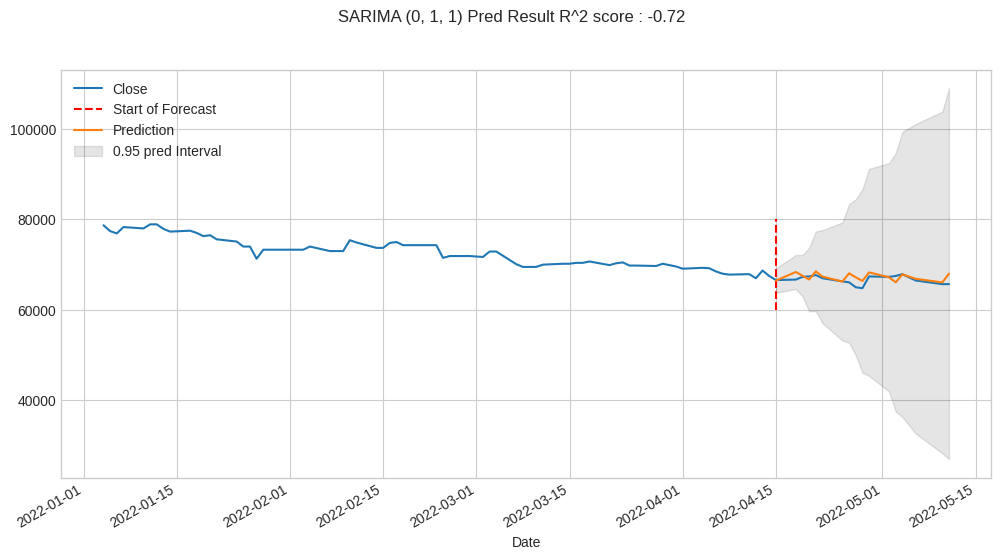

In [ ]:
pred = model_fit.get_forecast(len(test_data))
pred_val = pred.predicted_mean
pred_ub = pred.conf_int()[:, 0]
pred_lb = pred.conf_int()[:, 1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['Close'].values, pred_val)
fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax =ax)
ax.vlines('2022-04-15', 60000, 80000, linestyle='--',color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')

ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optim[0][0]} Pred Result R^2 score : {round(r2, 2)}')
plt.show()

In [ ]:
auto_arima_model = auto_arima(train_data['Close'],
                              start_p=1, start_q=1,  # p, q의 시작값을 설정 (AR, MA 차수)
                              max_p=3, max_1=3,     # p, q의 최대값을 설정
                              m=3,                  # 계절성 주기 (3 기간마다 계절성 패턴이 반복)
                              seasonal=True,        # SARIMA 모델 사용 여부 (계절성 포함)
                              d=1,                  # 차분 횟수 (일반 시계열 차분)
                              D=1,                  # 계절적 차분 횟수
                              max_P=3, max_Q=3,     # 계절적 AR, MA 차수의 최대값
                              trace=True,           # 모델의 적합 과정 출력 (진행 상황을 콘솔에 표시)
                              stepwise=False)       # 모든 조합에 대해 모델을 시도 (stepwise=False는 전체 탐색)

auto_arima_model.summary()

 ARIMA(0,1,0)(0,1,0)[3]             : AIC=1108.048, Time=0.03 sec
 ARIMA(0,1,0)(0,1,1)[3]             : AIC=1113.082, Time=0.05 sec
 ARIMA(0,1,0)(0,1,2)[3]             : AIC=1119.880, Time=0.06 sec
 ARIMA(0,1,0)(0,1,3)[3]             : AIC=1113.509, Time=0.38 sec
 ARIMA(0,1,0)(1,1,0)[3]             : AIC=1109.950, Time=0.10 sec
 ARIMA(0,1,0)(1,1,1)[3]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(1,1,2)[3]             : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(1,1,3)[3]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,0)(2,1,0)[3]             : AIC=1111.561, Time=0.12 sec
 ARIMA(0,1,0)(2,1,1)[3]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(2,1,2)[3]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(2,1,3)[3]             : AIC=1115.543, Time=0.67 sec
 ARIMA(0,1,0)(3,1,0)[3]             : AIC=1113.530, Time=0.19 sec
 ARIMA(0,1,0)(3,1,1)[3]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(3,1,2)[3]             : AIC=1099.576, Time=0.65 sec
 ARIMA(0,1,1)(0,1,0)[3]             : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   68
Model:             SARIMAX(0, 1, 0)x(3, 1, [1, 2], 3)   Log Likelihood                -543.788
Date:                                Sun, 08 Sep 2024   AIC                           1099.576
Time:                                        14:50:24   BIC                           1112.529
Sample:                                             0   HQIC                          1104.679
                                                 - 68                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L3       -1.6688      0.112    -14.868      0.000      -1.889      -1.449
ar.S.L6       -0.9290      0.135     -6.870      0.000      -1.194      -0.664
ar.S.L9       -0.0672      0.034     -1.981      0.048      -0.134      -0.001
ma.S.L3        1.6548      0.120     13.837      0.000       1.420       1.889
ma.S.L6        0.8678      0.141      6.146      0.000       0.591       1.145
sigma2      1.403e+06    1.1e-07   1.28e+13      0.000     1.4e+06     1.4e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 5.38
Prob(Q):                              0.78   Prob(JB):                         0.07
Heteroskedasticity (H):               0.33   Skew:                             0.45
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.72e+28. Standard errors may be unstable.
"""

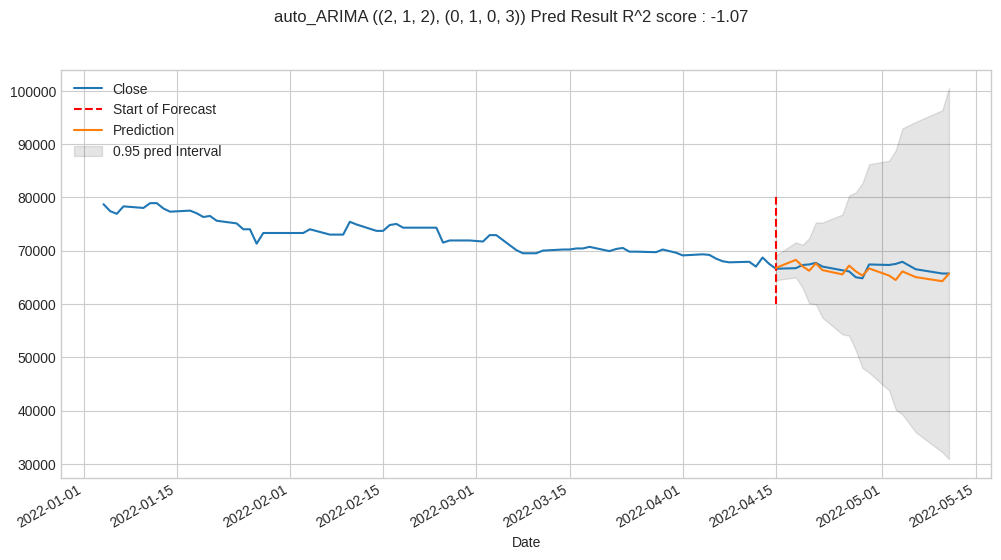

In [ ]:
pred = auto_arima_model.predict(len(test_data), return_conf_int=True)
pred_val = pred[0]
pred_ub = pred[1][:,0]
pred_lb = pred[1][:,1]
pred_index = list(test_data.index)
r2 = r2_score(test_data['Close'].values, pred_val)
fig, ax = plt.subplots(figsize=(12, 6))
df['Close'].plot(ax =ax)
ax.vlines('2022-04-15', 60000, 80000, linestyle='--',color='r', label='Start of Forecast')
ax.plot(pred_index, pred_val, label='Prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k', alpha=0.1, label='0.95 pred Interval')

ax.legend(loc='upper left')
plt.suptitle(f'auto_ARIMA {optim[0][0]} Pred Result R^2 score : {round(r2, 2)}')
plt.show()

In [ ]:
!pip install prophet

In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime

In [ ]:
import yfinance as yf
df = yf.download('005930.KS',
                     start='2018-03-01',
                     end='2022-04-01') # 005930 : 삼성전자 주가

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df['Close']

Date
2018-03-02    46020.0
2018-03-05    45200.0
2018-03-06    47020.0
2018-03-07    48620.0
2018-03-08    49200.0
               ...   
2022-03-25    69800.0
2022-03-28    69700.0
2022-03-29    70200.0
2022-03-30    69900.0
2022-03-31    69600.0
Name: Close, Length: 1004, dtype: float64

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.rename(columns={'Date':'ds'},inplace=True)
df.rename(columns={'Close':'y'},inplace=True)

In [ ]:
m = Prophet(yearly_seasonality=True, daily_seasonality=True) # 연간 주기로 반복되는 계절성 패턴을 모델에 포함
                                                            # 일별 계절성 패턴을 모델에 포함. 매일 반복되는 패턴
m.fit(df)
future = m.make_future_dataframe(periods=120)
forecast = m.predict(future)
forecast # yhat이 예측값.

DEBUG:cmdstanpy:input tempfile: /tmp/tmp111yih7m/b4qybpw2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp111yih7m/u0klbacu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77023', 'data', 'file=/tmp/tmp111yih7m/b4qybpw2.json', 'init=/tmp/tmp111yih7m/u0klbacu.json', 'output', 'file=/tmp/tmp111yih7m/prophet_modellp28nj9k/prophet_model-20240728144950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:49:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:49:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-03-02,46586.085000,50159.964416,55692.574247,46586.085000,46586.085000,6236.078110,6236.078110,6236.078110,3098.68832,...,69.759784,69.759784,69.759784,3067.630006,3067.630006,3067.630006,0.0,0.0,0.0,52822.163110
1,2018-03-05,46580.414827,49494.722438,54923.775047,46580.414827,46580.414827,5586.318714,5586.318714,5586.318714,3098.68832,...,91.130021,91.130021,91.130021,2396.500373,2396.500373,2396.500373,0.0,0.0,0.0,52166.733541
2,2018-03-06,46578.524769,49215.838851,54903.117576,46578.524769,46578.524769,5533.898339,5533.898339,5533.898339,3098.68832,...,258.528344,258.528344,258.528344,2176.681675,2176.681675,2176.681675,0.0,0.0,0.0,52112.423108
3,2018-03-07,46576.634711,49030.471939,54794.993685,46576.634711,46576.634711,5259.460451,5259.460451,5259.460451,3098.68832,...,199.024270,199.024270,199.024270,1961.747861,1961.747861,1961.747861,0.0,0.0,0.0,51836.095162
4,2018-03-08,46574.744653,48825.003963,54413.458538,46574.744653,46574.744653,5008.257736,5008.257736,5008.257736,3098.68832,...,156.229692,156.229692,156.229692,1753.339724,1753.339724,1753.339724,0.0,0.0,0.0,51583.002389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,2022-07-25,59923.270431,58011.781715,66577.205082,56784.270216,63415.361149,2203.519386,2203.519386,2203.519386,3098.68832,...,91.130021,91.130021,91.130021,-986.298954,-986.298954,-986.298954,0.0,0.0,0.0,62126.789818
1120,2022-07-26,59877.470258,58000.859785,66685.271724,56649.219106,63415.494277,2379.582148,2379.582148,2379.582148,3098.68832,...,258.528344,258.528344,258.528344,-977.634516,-977.634516,-977.634516,0.0,0.0,0.0,62257.052405
1121,2022-07-27,59831.670084,57738.090404,66708.864129,56501.185641,63382.942355,2318.810409,2318.810409,2318.810409,3098.68832,...,199.024270,199.024270,199.024270,-978.902181,-978.902181,-978.902181,0.0,0.0,0.0,62150.480493
1122,2022-07-28,59785.869911,57476.571577,66958.243076,56363.252433,63389.880927,2264.335298,2264.335298,2264.335298,3098.68832,...,156.229692,156.229692,156.229692,-990.582714,-990.582714,-990.582714,0.0,0.0,0.0,62050.205208


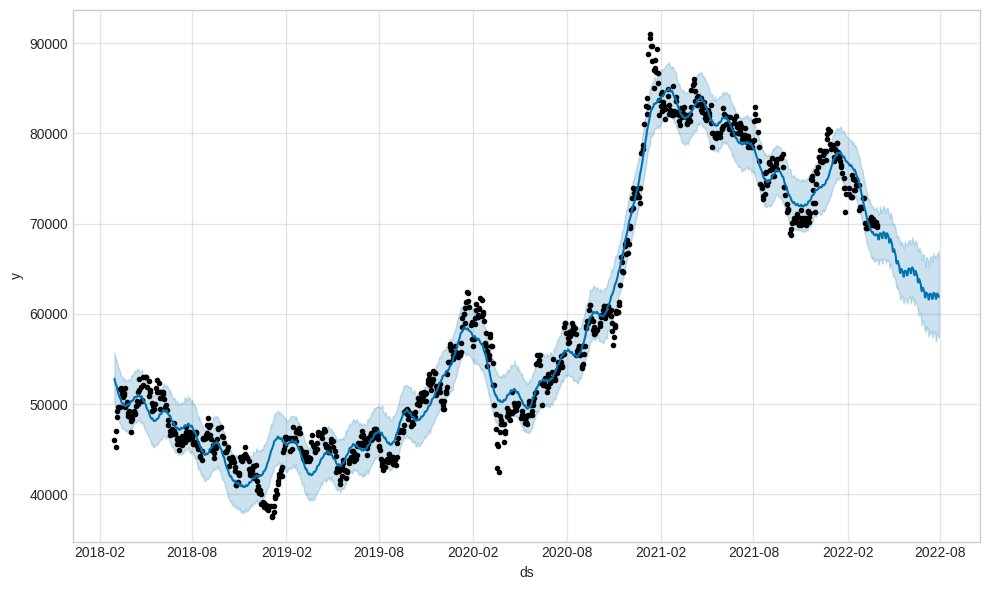

In [ ]:
m.plot(forecast)
plt.show()
